In [3]:
import numpy as np
import matplotlib.pyplot as plt
from nbody import Particles, NBodySimulator
from nbody import load_files, save_movie
from numba import set_num_threads

In [2]:
# Uncomment the following line to install required packages if needed

#!conda install -y -c conda-forge ffmpeg, glob, numba

# N-Body Simulation

In this notebook, we will test the `NBodySimulator` class in `./nbody/simulator.py`. 

In [3]:
# Set the number of threads to use for numba
nthreads = 6
set_num_threads(nthreads)

# Exercise 1: The Sun-Earth System

The first test is to implment the Sun-Earth system, which is a two body system. We need to make sure that you could simulate a circular motion first.

## Step 1. The initial condition

Copy the initial condition of the Earth-Sun system from `project2_demo1.ipynb`.

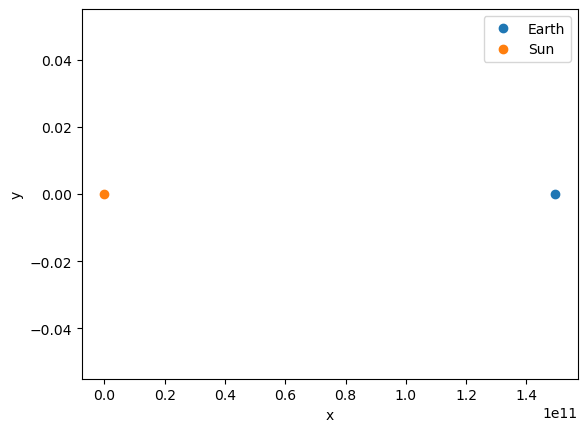

In [4]:
# TODO:
sun_mass = 1.989e30 # kg
earth_mass = 5.972e24 # kg
separation = 1.496e11 # m
period = 3.154e7 # s
r_sun = separation * earth_mass / (sun_mass + earth_mass)
r_earth = separation * sun_mass / (sun_mass + earth_mass)
vy_sun = 2 * np.pi * r_sun / period
vy_earth = 2 * np.pi * r_earth / period

pts = Particles(N=2)
pts.masses = np.array([[sun_mass], [earth_mass]])
pts.positions = np.array([[-r_sun, 0, 0], [r_earth, 0, 0]])
pts.velocities = np.array([[0, -vy_sun, 0], [0, vy_earth, 0]])
pts.accelerations = np.zeros((2, 3))
pts.tags = np.array([1, 2])

# visualize the system
plt.figure()
plt.plot(pts.positions[1, 0], pts.positions[1, 1], 'o', label='Earth')
plt.plot(pts.positions[0, 0], pts.positions[0, 1], 'o', label='Sun')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Step 2. N-body simulation

Make sure you have implmented the below two methods `setup()` and `evolve()`. Run the n-body simulation by:

In [5]:
simulation = NBodySimulator(pts)
simulation.setup(G=6.674e-11,rsoft=1e9,method='RK4', io_freq=30)
simulation.evolve(dt=8640, tmax=365*86400)

n = 0, T = 0.000, dt = 8640.000
n = 30, T = 259200.000, dt = 8640.000
n = 60, T = 518400.000, dt = 8640.000
n = 90, T = 777600.000, dt = 8640.000
n = 120, T = 1036800.000, dt = 8640.000
n = 150, T = 1296000.000, dt = 8640.000
n = 180, T = 1555200.000, dt = 8640.000
n = 210, T = 1814400.000, dt = 8640.000
n = 240, T = 2073600.000, dt = 8640.000
n = 270, T = 2332800.000, dt = 8640.000
n = 300, T = 2592000.000, dt = 8640.000
n = 330, T = 2851200.000, dt = 8640.000
n = 360, T = 3110400.000, dt = 8640.000
n = 390, T = 3369600.000, dt = 8640.000
n = 420, T = 3628800.000, dt = 8640.000
n = 450, T = 3888000.000, dt = 8640.000
n = 480, T = 4147200.000, dt = 8640.000
n = 510, T = 4406400.000, dt = 8640.000
n = 540, T = 4665600.000, dt = 8640.000
n = 570, T = 4924800.000, dt = 8640.000
n = 600, T = 5184000.000, dt = 8640.000
n = 630, T = 5443200.000, dt = 8640.000
n = 660, T = 5702400.000, dt = 8640.000
n = 690, T = 5961600.000, dt = 8640.000
n = 720, T = 6220800.000, dt = 8640.000
n = 750, T = 6

## Step 3. Visualization

Check the code in `./nobdy/visualization.py`.
Data loader is implmented in the function `load_files`.

In [6]:
fns = load_files('nbody')
print(fns)

['data_nbody\\nbody_000000.dat', 'data_nbody\\nbody_000030.dat', 'data_nbody\\nbody_000060.dat', 'data_nbody\\nbody_000090.dat', 'data_nbody\\nbody_000120.dat', 'data_nbody\\nbody_000150.dat', 'data_nbody\\nbody_000180.dat', 'data_nbody\\nbody_000210.dat', 'data_nbody\\nbody_000240.dat', 'data_nbody\\nbody_000270.dat', 'data_nbody\\nbody_000300.dat', 'data_nbody\\nbody_000330.dat', 'data_nbody\\nbody_000360.dat', 'data_nbody\\nbody_000390.dat', 'data_nbody\\nbody_000420.dat', 'data_nbody\\nbody_000450.dat', 'data_nbody\\nbody_000480.dat', 'data_nbody\\nbody_000510.dat', 'data_nbody\\nbody_000540.dat', 'data_nbody\\nbody_000570.dat', 'data_nbody\\nbody_000600.dat', 'data_nbody\\nbody_000630.dat', 'data_nbody\\nbody_000660.dat', 'data_nbody\\nbody_000690.dat', 'data_nbody\\nbody_000720.dat', 'data_nbody\\nbody_000750.dat', 'data_nbody\\nbody_000780.dat', 'data_nbody\\nbody_000810.dat', 'data_nbody\\nbody_000840.dat', 'data_nbody\\nbody_000870.dat', 'data_nbody\\nbody_000900.dat', 'data_n

Modify the matplotlib script 

In [7]:
au = 1.496e11
#save_movie(fns, lengthscale=2*au,filename='nbody_earth_sun.mp4', fps=10)

# Exercise 2: N-Body simulation

Now, let's test our n-body solver with more particles. Copy the initial condition from the Exercise 2 in `project2_demo1.ipynb`.

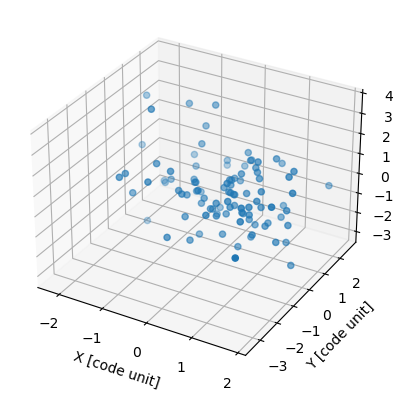

In [8]:
# TODO

num_particles = 100
pts = Particles(N=num_particles)
pts.masses = np.ones((num_particles, 1))* 10/num_particles
pts.positions = np.random.randn(num_particles, 3)
pts.velocities = np.random.randn(num_particles, 3)
pts.accelerations = np.zeros((num_particles, 3))

# visualize the system
pts.draw(dim=3)

## Step 2. Simulation.

Visualize the system but use dimensionless units. Set `G=1` and `rsoft=0.001`.

In [9]:
#simulation = NBodySimulator(particles=pts)
#simulation.setup(G=1,rsoft=0.001,method='RK4', io_freq=10, io_header='cluster')
#simulation.evolve(dt=0.01, tmax=1)

It is VERY slow !!!!

Beacuse the accerlation calculations requires order of NxN calculations!
Could we improve it?

First, we should avoid the two "for" loops in the calculation using python.\
Second, we have many cup cores in our machine. Could we parallelize it?

# `numba`

Step 1. Take out the function to calculate the accerlation from the class into a pure function that only counts math calculations (aka. a kernel).

Step 2. Use the `numba`'s `@jit` micro. 

Results: In my experiments. I got roughly x140 speed up with the @jit(nopython=True). 

Step 3. Try using `@njit` and `prange` in numba.

## Performance

### Strong Scaling Test

**Strong scaling**: The number of processors is increased while the problem size remains constant.\
We could use `%timeit` to measure the performance. Let's run 1000 particles for 10 step.

In [10]:
nthreads = 1
set_num_threads(nthreads)

num_particles = 1000
pts = Particles(N=num_particles)
pts.masses = np.ones((num_particles, 1))* 10/num_particles
pts.positions = np.random.randn(num_particles, 3)
pts.velocities = np.random.randn(num_particles, 3)
pts.accelerations = np.zeros((num_particles, 3))

simulation = NBodySimulator(particles=pts)
simulation.setup(G=1,rsoft=0.001,method='RK4', io_screen=False, io_freq=10, io_header='cluster')
simulation.evolve(dt=0.02, tmax=1)

In [11]:
%timeit simulation.evolve(dt=0.02, tmax=0.2)

Simulation is done!
Simulation is done!
Simulation is done!
Simulation is done!
Simulation is done!
Simulation is done!
Simulation is done!
Simulation is done!
25.6 s ± 3.87 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Kuo-Chuan's measurements**

CPU: 3 GHz 10-Core Intel Xeon W

1000 particles. 10 steps.

without `numba`: 5min 31s ± 2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
with `numba`:
* 1 core (`jit`): 17.7 s ± 328 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
* 1 core (`njit`): 10.4 s ± 337 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
* 2 cores: 7.61 s ± 52.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
* 6 cores: 3.35 s ± 50.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
* 10 cores: 2.12 s ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
* 12 cores: 1.95 s ± 36.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
* 16 cores: 1.64 s ± 46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
* 20 cores: 1.49 s ± 55.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

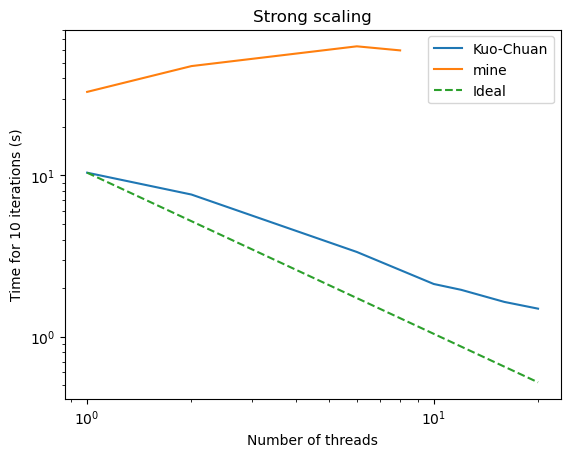

In [4]:
threads = [1,2,6,10,12,16,20]                     # Replace it to your measured values
threads1 = [1,2,6,8]
times1 = [23.1/7*10, 33.4/7*10, 44.3/7*10, 41.8/7*10]
times = [10.4, 7.61, 3.35, 2.12, 1.95, 1.64,1.49] # Replace it to your measured values
ideal = times[0]/np.array(threads)
plt.loglog(threads, times)
plt.loglog(threads1, times1)
plt.loglog(threads, ideal, '--')
plt.xlabel('Number of threads')
plt.ylabel('Time for 10 iterations (s)')
plt.legend(['Kuo-Chuan', 'mine', 'Ideal'])
plt.title('Strong scaling')
plt.show()

## Weak Scaling Test

In N-body simulation, the problem size is proportional to $N^2$.\
**Weaking scaling** test measures the scaling with the same problem size per thread (core).

In [13]:
nthreads = 2
set_num_threads(nthreads)
num_particles = int(225*np.sqrt(nthreads))
print("N =", num_particles, ", threads = ", nthreads)
pts = Particles(N=num_particles)
pts.masses = np.ones((num_particles, 1))* 10/num_particles
pts.positions = np.random.randn(num_particles, 3)
pts.velocities = np.random.randn(num_particles, 3)
pts.accelerations = np.zeros((num_particles, 3))

simulation = NBodySimulator(particles=pts)
simulation.setup(G=1,rsoft=0.001,method='RK4', io_screen=False, io_freq=10, io_header='cluster')

N = 318 , threads =  2


In [14]:
%timeit simulation.evolve(dt=0.02, tmax=0.2)

Simulation is done!
Simulation is done!
Simulation is done!


SystemError: CPUDispatcher(<function acc_gravity at 0x00000244A0012F80>) returned a result with an exception set

Kuo-Chuan's measurements

* N = 225 threads =  1: 537 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
* N = 450 threads =  4: 981 ms ± 17.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
* N = 636 threads =  8: 1.07 s ± 22.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
* N = 779 threads =  12: 1.17 s ± 33.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
* N = 900 threads =  16: 1.29 s ± 6.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
* N = 1006 threads =  20: 1.51 s ± 35.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

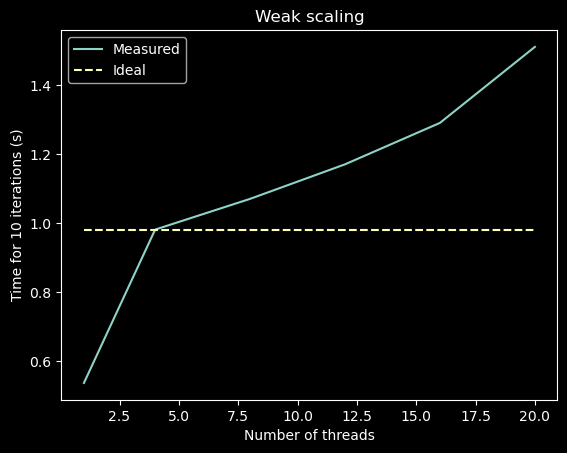

In [ ]:
threads = [1,4,8,12,16,20]                     # Replace it to your measured values
times = [0.537, 0.981, 1.07, 1.17, 1.29, 1.51] # Replace it to your measured values
ideal = 0.981 * np.ones(len(threads))
plt.plot(threads, times)
plt.plot(threads, ideal, '--')
plt.xlabel('Number of threads')
plt.ylabel('Time for 10 iterations (s)')
plt.legend(['Measured', 'Ideal'])
plt.title('Weak scaling')
plt.show()